# 🤖 DEITA: Data-Efficient Instruction Tuning for Alignment
# What Makes Good Data for Alignment? A Comprehensive Study of Automatic Data Selection in Instruction Tuning

DEITA (Data-Efficient Instruction Tuning for Alignment) studies an automatic data selection process by first quantifying the data quality based on  complexity, quality and diversity. And second, selecting across the best potential combination from an open-source dataset that would fit into the budget you allocate to tune your own LLM.

In most setting we cannot allocate unlimited resources for instruction-tuning LLMs. Therefore, the DEITA authors investigated how to select qualitative data for instruction-tuning based on a principle of fewer high quality samples. Liu et al. tackle the issue of first defining good data and second identifying it to respect an initial budget to instruct-tune your LLM. 

The strategy utilizes **LLMs to replace human effort in time-intensive data quality tasks on instruction tuning datasets**. DEITA introduces a way to measure data quality across three critical dimensions: complexity, quality and diversity.

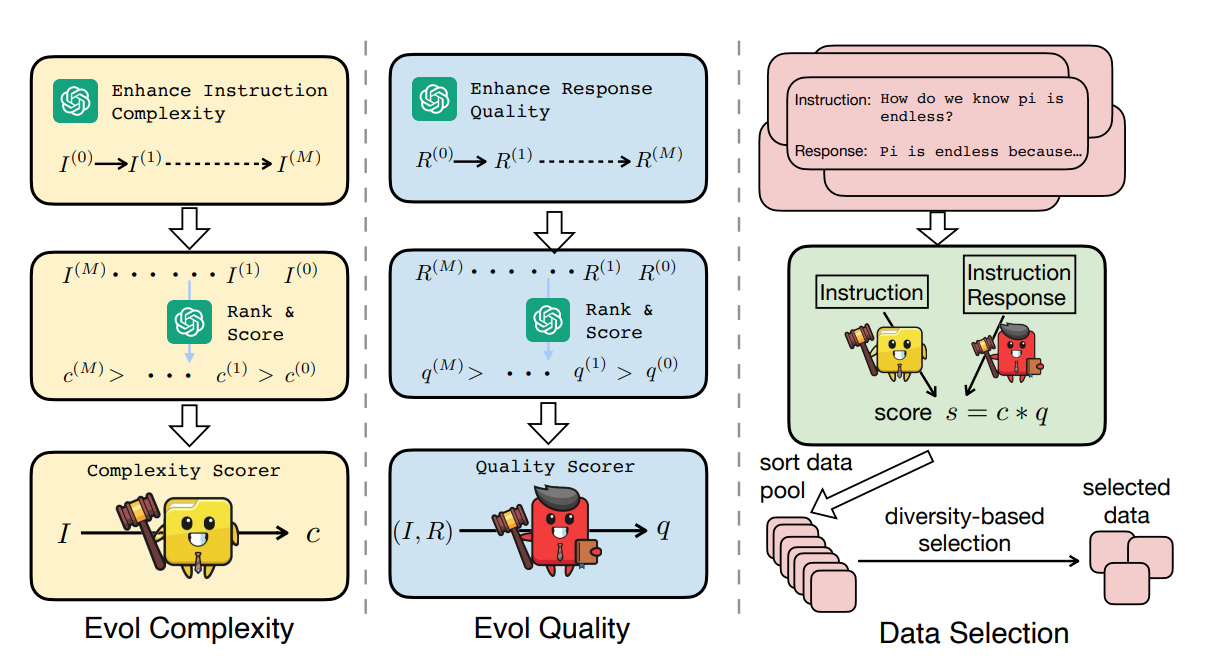

You can see that we see again the dataset of instructions/responses and we kind of reproducing the second step when we learn how to optimize the responses according to an instruction by comparing several possibilities.

## Datasets and budget

We will dive deeper into the whole process. We will investigate each stage to efficiently select the final dataset used for supervised fine-tuning with a budget constraint. We will tackle technical challenges by explaining exactly how you would assess good data as presented in the paper.

As a reminder, we’re looking for a strategy to automatically select good data for the instruction-tuning step when you want to fine-tune an LLM to your own use case taking into account a resource constraint. This means that you cannot blindly train a model on any data you encounter on the internet.

The DEITA authors assume that you have access to open-source datasets that fit your use case. This may not be the case entirely. But with open-source communities tackling many use cases, with projects such as [BLOOM](https://arxiv.org/pdf/2110.08207.pdf) or [AYA](https://cohere.com/research/aya), it’s likely that your use case will be tackled at some point. Furthermore, you could generate your own instruction/response pairs with methods such as [self-generated instructions](https://aclanthology.org/2023.acl-long.754/) using distilabel. This tutorial assumes that we have a data pool with excessive samples for the project’s cost constraint. In short, we aim to achieve adequate performance from fewer samples.

The authors claim that the subsample size “correlates proportionally with the computation consumed in instruction tuning”. Hence on a first approximation, reducing the sample size means reducing computation consumption and so the total development cost. Reproducing the paper notations, we will associate the budget m to a number of instruction/response pairs that you can set depending on your real budget.

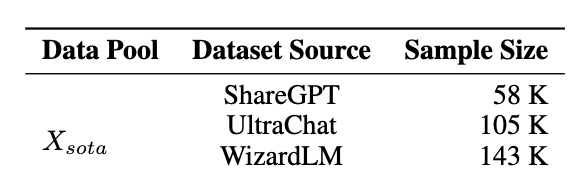

To match the experimental set-up, dataset *X\_sota* is a meta-dataset
combining major open-source datasets available to instruct-tune LLMs.
This dataset is composed of
[ShareGPT](https://huggingface.co/datasets/shibing624/sharegpt_gpt4)
(58k instruction/response pairs),
[UltraChat](https://huggingface.co/datasets/stingning/ultrachat)
(105k instruction/response pairs) and
[WizardLM](https://github.com/nlpxucan/WizardLM) (143k
instruction/response pairs). It sums to more than 300k
instruction/response pairs. We aim to reduce the final subsample to 6k
instruction/response pairs.

# 0. Setup the notebook and packages

Let's prepare our dependencies

In [ ]:
%pip install -qqq git+https://github.com/argilla-io/distilabel.git@better_logging#egg=distilabel[openai,hf-transformers]
%pip install -qqq pynvml

In [ ]:
import os

try:
    from google.colab import userdata

    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
except ImportError:
    pass

SecretNotFoundError: Secret OPENAI_API_KEY does not exist.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from distilabel.llm.huggingface.transformers import TransformersLLM
from distilabel.llm.openai import OpenAILLM
from distilabel.pipeline.local import Pipeline
from distilabel.steps.conversation import ConversationTemplate
from distilabel.steps.deita import DeitaFiltering
from distilabel.steps.expand import ExpandColumns
from distilabel.steps.generators.huggingface import LoadHubDataset
from distilabel.steps.task.complexity_scorer import ComplexityScorer
from distilabel.steps.task.evol_instruct.base import EvolInstruct
from distilabel.steps.task.evol_quality.base import EvolQuality
from distilabel.steps.task.generate_embeddings import GenerateEmbeddings
from distilabel.steps.task.quality_scorer import QualityScorer

# 1. EVOL-INSTRUCT: Generate Instructions with an LLM

[Evol-Instruct](https://arxiv.org/abs/2304.12244)
automates the creation of complex instruction data for training large
language models (LLMs) by progressively rewriting an initial set of
instructions into more complex forms. This generated data is then used
to fine-tune a model named WizardLM. Evaluations show that instructions
from Evol-Instruct are superior to human-created ones, and WizardLM
achieves performance close to or exceeding GPT3.5-turbo in many skills.

In distilabel 1.0, we initialise each step of the data generation pipeline. Later, we'll connect them together.

```python
    evol_instruction_complexity = EvolInstruct(
        name="evol_instruction_complexity",
        llm=OpenAILLM(model="gpt-3.5-turbo"),
        num_evolutions=5,
        store_evolutions=True,
        generate_answers=True,
        include_original_instruction=True,
    )

```

# 2. EVOL COMPLEXITY: Evaluate complexity of generated instructions

The second step is the evaluation of *complexity* for an instruction in
a given instruction-response pair. Like EVOL-INSTRUCT, this method
leverages LLMs instead of humans to automatically score instructions.
From any instruction-response pair, *(I, R)*, we first generate new
instructions following the In-Depth Evolving Response. We generate more
complex instructions through prompting, as explained by authors, by
adding some constraints or reasoning steps. Let's take an example from
[GPT-4-LLM](https://github.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM)
which aims to generate observations by GPT-4 to instruct-tune LLMs with
supervised fine-tuning. And, we have the instruction *instruction\_0*:

```python
instruction_0 = "Give three tips for staying healthy."
```

To make it more complex, you can use, as the authors did, some prompt templates to add constraints or deepen the instruction. They provided some prompts in the paper appendix. For instance, this one was used to add constraints:


In [ ]:
PROMPT = """
I want you act as a Prompt Rewriter.
Your objective is to rewrite a given prompt into a more complex version to
make those famous AI systems (e.g., ChatGPT and GPT4) a bit harder to handle.
But the rewritten prompt must be reasonable and must be understood and
responded by humans.
Your rewriting cannot omit the non-text parts such as the table and code in
#Given Prompt#:. Also, please do not omit the input in #Given Prompt#.
You SHOULD complicate the given prompt using the following method:
Please add one more constraints/requirements into #Given Prompt#
You should try your best not to make the #Rewritten Prompt# become verbose,
#Rewritten Prompt# can only add 10 to 20 words into #Given Prompt#.
‘#Given Prompt#’, ‘#Rewritten Prompt#’, ‘given prompt’ and ‘rewritten prompt’
are not allowed to appear in #Rewritten Prompt#
#Given Prompt#:
<Here is instruction>
#Rewritten Prompt#:

Prompting this to an LLM, you automatically get a more complex instruction, called instruction_1, from an initial instruction instruction_0:

In [ ]:
instruction_1 = "Provide three recommendations for maintaining well-being, ensuring one focuses on mental health."

With sequences of evolved instructions, we use a further LLM to automatically rank and score them. We provide the 6 instructions at the same time. By providing all instructions together, we force the scoring model to look at minor complexity differences between evolved instructions. Encouraging the model to discriminate between instructions. Taking the example below, instruction_0 and instruction_1 could deserve the same score independently, but when compared together we would notice the slight difference that makes instruction_1 more complex.

|      | Instruction |
| ---- | ----------- |
| 0    | Give three tips for staying healthy.            |
| 1    | Provide three recommendations for maintaining well-being, ensuring one focuses on mental health. |


In distilabel 1.0, we implement this like so:

```python
instruction_complexity_scorer = ComplexityScorer(
        name="instruction_complexity_scorer",
        llm=OpenAILLM(model="gpt-3.5-turbo"),
        input_mappings={"instructions": "evolved_instructions"},
)
```



# 3. EVOL-QUALITY: Quality Evaluation

Now that we have scored the *complexity* of the instructions, we will focus on the *quality* of the responses. Similar to *EVOL COMPLEXITY*, the authors introduced *EVOL QUALITY, a method* based on LLMs, instead
of humans, to automatically score the quality of the response.

From an instruction-response pair, *(I, R)*, the goal is to make the response evolve into a more helpful and relevant response. The key difference is that we need to also provide the first instruction to guide evolution. Let's take back our example from [GPT-4-LLM](https://github.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM).

Here we have the response *response\_0* and its initial instruction *instruction\_0*:


In [ ]:
instruction_0 = "Give three tips for staying healthy."
reponse_0 = "1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases. 2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week. 3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night."

Again the authors provided several prompts you could use to make your response evolve according to some guidelines. For example, this one was used to enrich the answer:



In [ ]:
PROMPT = """
I want you to act as a Response Rewriter
Your goal is to enhance the quality of the response given by an AI assistant
to the #Given Prompt# through rewriting.
But the rewritten response must be reasonable and must be understood by humans.
Your rewriting cannot omit the non-text parts such as the table and code in
#Given Prompt# and #Given Response#. Also, please do not omit the input
in #Given Prompt#.
You Should enhance the quality of the response using the following method:
Please make the Response more in-depth
You should try your best not to make the #Rewritten Response# become verbose,
#Rewritten Response# can only add 10 to 20 words into #Given Response#.
‘#Given Response#’, ‘#Rewritten Response#’, ‘given response’ and ‘rewritten response’
are not allowed to appear in #Rewritten Response#
#Given Prompt#:
<instruction_0>
#Given Response#:
<response_0>
#Rewritten Response#:
"""

Prompting this to an LLM, you will automatically get a more enriched response, called response_1, from an initial response response_0 and initial instruction instruction_0:

In [ ]:
response_1 = "1. Consume a well-rounded diet: Incorporate a diverse array of fruits, vegetables, lean proteins, whole grains, and beneficial fats into your meals. This diversity ensures your body receives the vital nutrients needed for optimal functionality and helps in warding off chronic health conditions. 2. Commit to consistent physical activity: Regular exercise is fundamental for sustaining robust skeletal and muscular health, as well as cardiovascular vitality. Strive for a weekly total of 150 minutes of moderate-intensity aerobic activity or 75 minutes of high-intensity exercise. 3. Prioritize adequate sleep: Ensuring sufficient, quality sleep is essential for both physical and mental health. It plays a key role in mood regulation, cognitive performance, and supports the body's growth and immune responses. Target 7-9 hours of restful sleep per night."

And now, as in EVOL COMPLEXITY you iterate through this path and use different prompts to make your responses more relevant, helpful or creative. In the paper, they make 4 more iterations to get 5 evolved responses (R0,R1, R2, R3, R4 ) which makes 5 different responses for one initial instruction at the end of this step.

In distilabel 1.0 we implement this like so:

```python
response_quality_scorer = QualityScorer(
    name="response_quality_scorer",
    llm=OpenAILLM(model="gpt-3.5-turbo"),
    input_mappings={
        "instruction": "evolved_instruction",
        "responses": "evolved_responses",
    },
)
```

# 4. Improving Data Diversity

One main component of good data to instruct-tune LLMs is diversity. Real world data can often contain [redundancy](https://openreview.net/forum?id=u96ZBg_Shna) due repetitive and homogenous data.

The authors of the DEITA paper tackle the challenge of ensuring data diversity in the instruction tuning LLMs to avoid the pitfalls of data redundancy that can lead to overfitting or poor generalization. They propose an embedding-based method to filter data for diversity. This method, called Repr Filter, uses embeddings generated by the LLaMA-1 13B model to represent instruction-response pairs in a vector space. The diversity of a new data sample is assessed based on the cosine distance between its embedding and that of its nearest neighbor in the already selected dataset. If this distance is greater than a specified threshold, the sample is considered diverse and is added to the selection. This process prioritizes diversity by assessing each sample's contribution to the variety of the dataset until the data selection budget is met. This approach effectively maintains the diversity of the data used for instruction tuning, as demonstrated by the DEITA models outperforming or matching state-of-the-art models with significantly less training data.

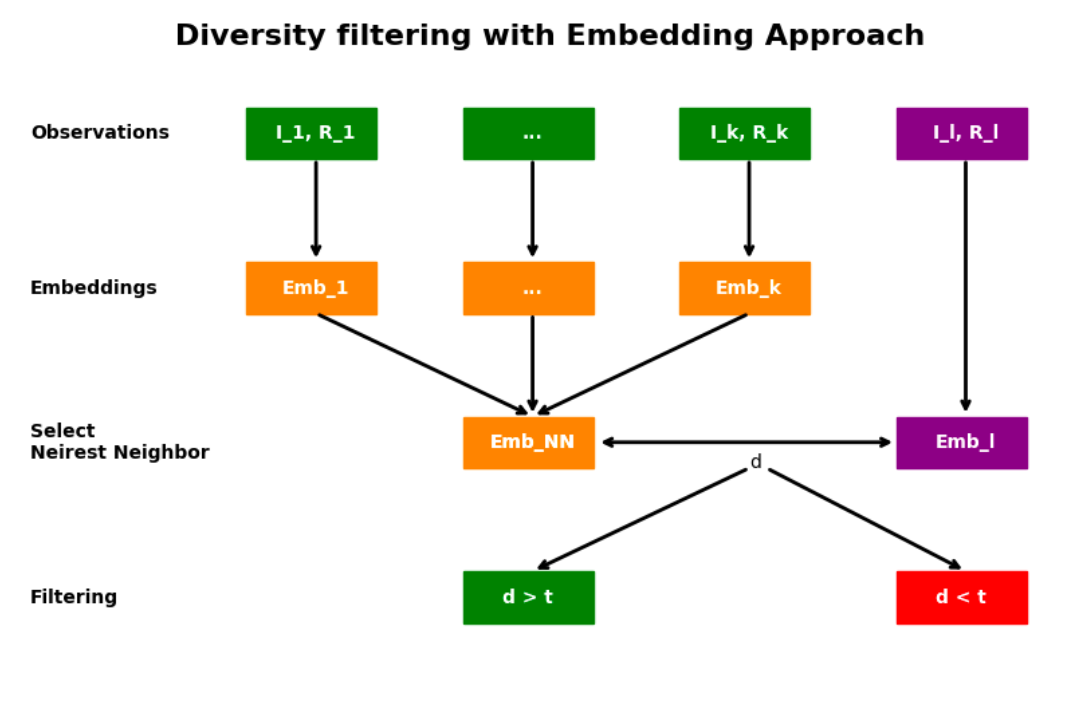


# Build the ⚗ distilabel `Pipeline`

Now we're ready to build a distilabel 1.0 pipeline using the DEITA method.

In [ ]:
with Pipeline(name="DEITA") as pipeline:
    load_data = LoadHubDataset(
        name="load_data", batch_size=100, output_mappings={"prompt": "instruction"}
    )

    evol_instruction_complexity = EvolInstruct(
        name="evol_instruction_complexity",
        llm=OpenAILLM(model="gpt-3.5-turbo"),
        num_evolutions=5,
        store_evolutions=True,
        generate_answers=True,
        include_original_instruction=True,
    )

    instruction_complexity_scorer = ComplexityScorer(
        name="instruction_complexity_scorer",
        llm=OpenAILLM(model="gpt-3.5-turbo"),
        input_mappings={"instructions": "evolved_instructions"},
    )

    expand_evolved_instructions = ExpandColumns(
        name="expand_evolved_instructions",
        columns=["evolved_instructions", "answers", "scores"],
        output_mappings={
            "evolved_instructions": "evolved_instruction",
            "answers": "answer",
            "scores": "evol_instruction_score",
        },
    )

    evol_response_quality = EvolQuality(
        name="evol_response_quality",
        llm=OpenAILLM(model="gpt-3.5-turbo"),
        num_evolutions=5,
        store_evolutions=True,
        include_original_response=True,
        input_mappings={
            "instruction": "evolved_instruction",
            "response": "answer",
        },
    )

    response_quality_scorer = QualityScorer(
        name="response_quality_scorer",
        llm=OpenAILLM(model="gpt-3.5-turbo"),
        input_mappings={
            "instruction": "evolved_instruction",
            "responses": "evolved_responses",
        },
    )

    expand_evolved_responses = ExpandColumns(
        name="expand_evolved_responses",
        columns=["evolved_responses", "scores"],
        output_mappings={
            "evolved_responses": "evolved_response",
            "scores": "evol_response_score",
        },
    )

    generate_conversation = ConversationTemplate(
        name="generate_conversation",
        input_mappings={
            "instruction": "evolved_instruction",
            "response": "evolved_response",
        },
    )

    generate_embeddings = GenerateEmbeddings(
        name="generate_embeddings",
        llm=TransformersLLM(
            model="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
            device="cuda",
            torch_dtype="float16",
        ),
        input_mappings={"text": "conversation"},
        input_batch_size=5,
    )

    deita_filtering = DeitaFiltering(name="deita_filtering")

We need to connect steps together to pass data between them:

In [ ]:
load_data.connect(evol_instruction_complexity)
evol_instruction_complexity.connect(instruction_complexity_scorer)
instruction_complexity_scorer.connect(expand_evolved_instructions)
expand_evolved_instructions.connect(evol_response_quality)
evol_response_quality.connect(response_quality_scorer)
response_quality_scorer.connect(expand_evolved_responses)
expand_evolved_responses.connect(generate_conversation)
generate_conversation.connect(generate_embeddings)
generate_embeddings.connect(deita_filtering)

Now we can run the pipeline. We use the step names to reference them in the pipeline configuration.

In [ ]:
distiset = pipeline.run(
    parameters={
        "load_data": {
            "repo_id": "distilabel-internal-testing/instruction-dataset-50",
            "split": "train",
        },
        "evol_instruction_complexity": {
            "llm": {"generation_kwargs": {"max_new_tokens": 512, "temperature": 0.7}}
        },
        "instruction_complexity_scorer": {
            "llm": {"generation_kwargs": {"temperature": 0.0}}
        },
        "evol_response_quality": {
            "llm": {"generation_kwargs": {"max_new_tokens": 512, "temperature": 0.7}}
        },
        "response_quality_scorer": {"llm": {"generation_kwargs": {"temperature": 0.0}}},
        "deita_filtering": {"data_budget": 500, "diversity_threshold": 0.04},
    },
    use_cache=False,
)

We can push the results to the hub.

In [ ]:
distiset.push_to_hub("distilabel-internal-testing/deita-colab")

# Results
Again, to show the relevance of EVOL QUALITY method, the authors evaluated on the MT-bench models fine-tuned with different data selections according to how we defined quality responses according to an instruction. Each time they selected 6k data according to the quality score:

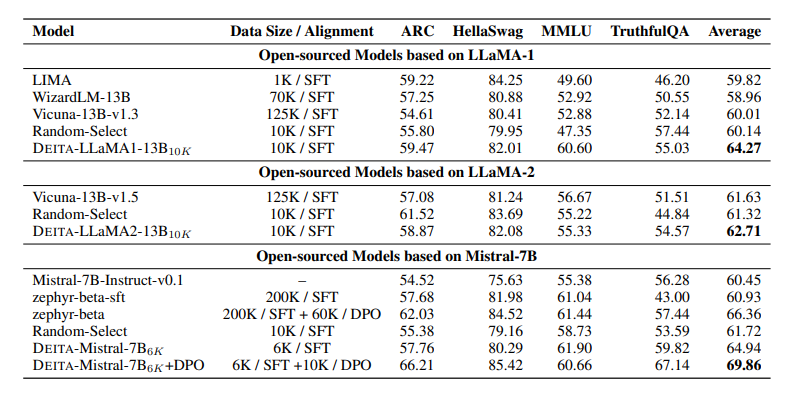

Credit: Liu et al. (2023)

The score is much better when selecting data with the EVOL QUALITY method than when we select randomly or according to the length, making a more qualitative response if longer. Nevertheless, we see that the margin we may have seen in the complexity score is thinner. And we’ll discuss the strategy in a later part.
Nevertheless, this strategy looks to improve the fine-tuning compared to the baselines and now we’re interested in mixing quality and complexity assessment with a diversity evaluation to find the right trade-off in our selection process.

# Conclusion

In conclusion, if you are looking for some efficient method to align an open-source LLM to your business case with a constrained budget, the solutions provided by DEITA are really worth the shot. This data-centric approach enables one to focus on the content of the dataset to have the best results instead of “just” scaling the instruction-tuning with more, and surely less qualitative, data. In a nutshell, the strategy developed, through automatically scoring instructions-responses, aims to substitute the human preference step proprietary models such as GPT-4 have been trained with. There are a few improvements we could think about when it comes to how to select the good data, but it opens a really great way in instruct-tuning LLM with lower computational needs making the whole process intellectually relevant and more sustainable than most of the other methods. We’d be happy to help you out with aligning an LLM with your business case drawing inspiration from such a methodology.